In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
# import ace_tools as tools
import matplotlib.pyplot as plt


In [2]:
# load data file
data = pd.read_csv("data/2024-09-20_data (2)/parametric_modulation_data.csv")


In [4]:
columns = [
    "Date", "Time", "B_freq", "B_ampl", 
    "g1_x", "g1_y", "g1_z", "g2_x", "g2_y", "g2_z",
    "x_offset", "y_offset", "z_offset"
]
results = pd.DataFrame(columns=columns)

# Constants for gradient calculations
CONST_B1_XY = 76.8500949
CONST_B1_Z = 1927.272727
CONST_B2_XY = 76.8500949
CONST_B2_Z = 1927.272727

# Iterate over the data in chunks of 7 rows
for i in range(0, len(data), 7):
    chunk = data.iloc[i:i+7]
    if len(chunk) < 7:
        break  # Skip incomplete chunks

    # Extract relevant data
    date = chunk.iloc[0]['Date']
    time = chunk.iloc[0]['Time']
    b_freq = chunk.iloc[0]['B_freq']
    b_ampl = chunk.iloc[0]['B_ampl']
    x_offset = chunk.iloc[0]['x_offset']
    y_offset = chunk.iloc[0]['y_offset']
    z_offset = chunk.iloc[0]['z_offset']

    # Determine rows to use for gradient calculations
    rows_for_gx = [5, 6]  # Use rows 1, 6, 7 for g_x calculation
    rows_for_gy = [1, 2]  # Use rows 1, 2, 3 for g_y calculation
    rows_for_gz = [3, 4]  # Use rows 1, 4, 5 for g_z calculation

    # Helper function to calculate gradient while avoiding division by near-zero values
    def calculate_gradient(delta_offset, delta_r, constant):
        valid_indices = np.where(np.abs(delta_r) > 1e-9)[0]  # Filter out near-zero differences
        if len(valid_indices) == 0:
            return 0  # Return 0 if no valid differences are found
        return (delta_r[valid_indices]/(delta_offset[valid_indices] * constant) ).mean() # change it 

    # Calculate gradients for B1 (using R1)
    delta_r1_gx = chunk['R1'].iloc[rows_for_gx].diff().iloc[1:].values
    delta_r1_gy = chunk['R1'].iloc[rows_for_gy].diff().iloc[1:].values
    delta_r1_gz = chunk['R1'].iloc[rows_for_gz].diff().iloc[1:].values

    delta_x_offset = chunk['x_offset'].iloc[rows_for_gx].diff().iloc[1:].values
    delta_y_offset = chunk['y_offset'].iloc[rows_for_gy].diff().iloc[1:].values
    delta_z_offset = chunk['z_offset'].iloc[rows_for_gz].diff().iloc[1:].values

    g1_x = calculate_gradient(delta_x_offset, delta_r1_gx, CONST_B1_XY)
    g1_y = calculate_gradient(delta_y_offset, delta_r1_gy, CONST_B1_XY)
    g1_z = calculate_gradient(delta_z_offset, delta_r1_gz, CONST_B1_Z)

    # Calculate gradients for B2 (using R2)
    delta_r2_gx = chunk['R2'].iloc[rows_for_gx].diff().iloc[1:].values
    delta_r2_gy = chunk['R2'].iloc[rows_for_gy].diff().iloc[1:].values
    delta_r2_gz = chunk['R2'].iloc[rows_for_gz].diff().iloc[1:].values

    g2_x = calculate_gradient(delta_x_offset, delta_r2_gx, CONST_B2_XY)
    g2_y = calculate_gradient(delta_y_offset, delta_r2_gy, CONST_B2_XY)
    g2_z = calculate_gradient(delta_z_offset, delta_r2_gz, CONST_B2_Z)

    # Append results to the DataFrame
    new_row = pd.DataFrame({
        "Date": [date],
        "Time": [time],
        "B_freq": [b_freq],
        "B_ampl": [b_ampl],
        "g1_x": [g1_x],
        "g1_y": [g1_y],
        "g1_z": [g1_z],
        "g2_x": [g2_x],
        "g2_y": [g2_y],
        "g2_z": [g2_z],
        "x_offset": [x_offset],
        "y_offset": [y_offset],
        "z_offset": [z_offset]
    })
    results = pd.concat([results, new_row], ignore_index=True)


/tmp/ipykernel_544660/3070461047.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


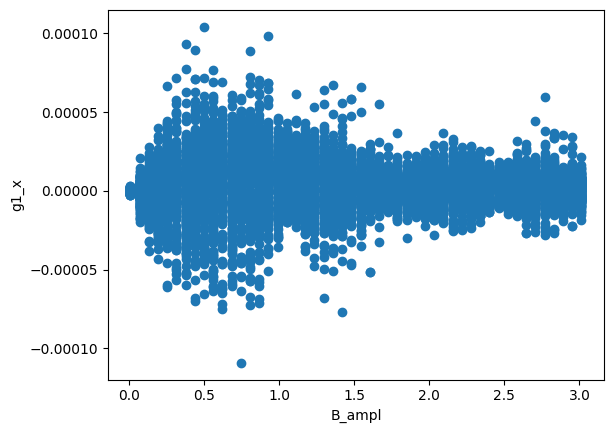

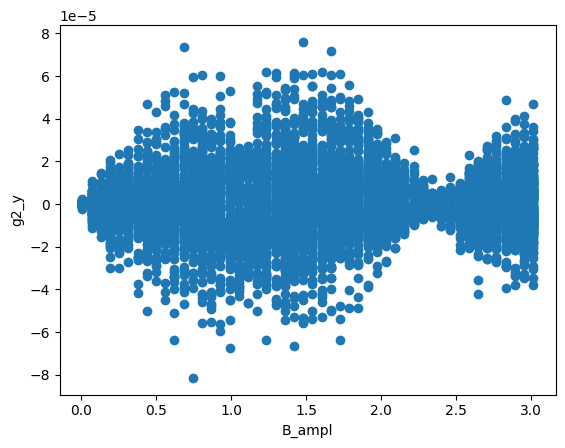

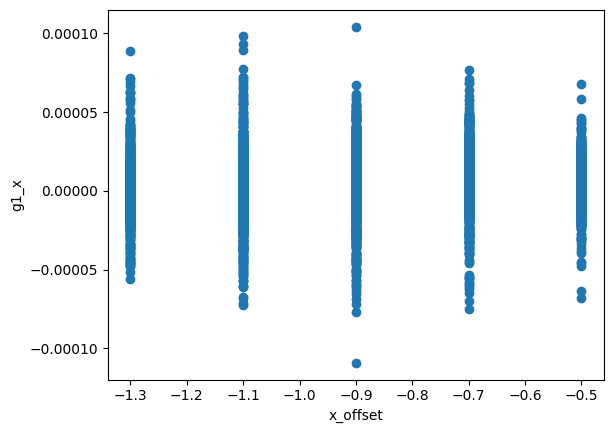

In [5]:
# plot out the gradients g1_x, g2_y as a function of B_ampl or x_offset
plt.figure()
plt.scatter(results["B_ampl"], results["g1_x"])
plt.xlabel("B_ampl")    
plt.ylabel("g1_x")
plt.show()

plt.figure()
plt.scatter(results["B_ampl"], results["g2_y"])
plt.xlabel("B_ampl")
plt.ylabel("g2_y")
plt.show()

plt.figure()
plt.scatter(results["x_offset"], results["g1_x"])
plt.xlabel("x_offset")
plt.ylabel("g1_x")
plt.show()

  







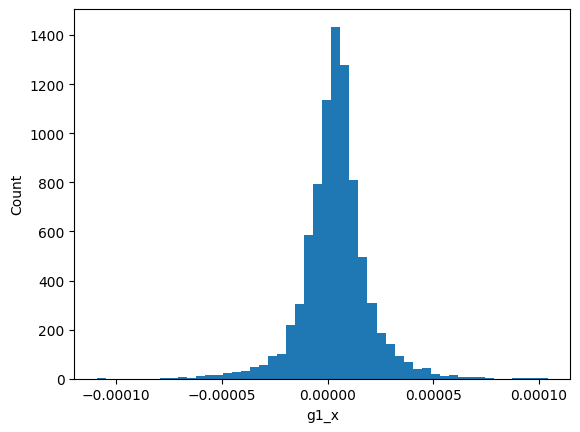

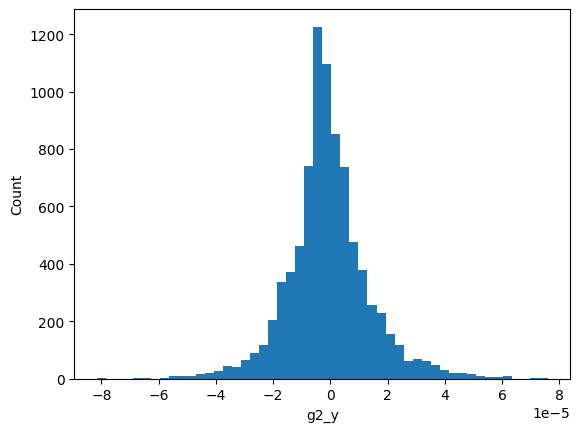

In [6]:
# plot the distrubiton of the gradients g1_x, g2_y
plt.figure()
plt.hist(results["g1_x"], bins=50)
plt.xlabel("g1_x")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(results["g2_y"], bins=50)
plt.xlabel("g2_y")
plt.ylabel("Count")
plt.show()


In [7]:
output_csv_path = '/home/guoguo/projects/QML/data/gradient_results_new.csv'
results.to_csv(output_csv_path, index=False)

In [8]:
# cost : sqrt(g1)